This notebook demonstrates extracting AEM conductivity data and gridding it using GDAL.

Neil Symington

neil.symington@ga.gov.au

In [44]:
import netCDF4
import numpy as np
from geophys_utils._netcdf_line_utils import NetCDFLineUtils, NetCDFPointUtils
import fiona
from osgeo import gdal, ogr
from shapely.geometry import Polygon, shape
import os
import tempfile

In [2]:
 # Import the AEM conductivity data
    

ncdir = r'\\prod.lan\active\proj\futurex\East_Kimberley\Data\Processed\Geophysics\AEM\EK_nbc_inversions\OrdKeep_borehole_constrained\netcdf'

# Open the file with the conductivity values
# The conductivity model was a 2d correlated borehole
# constrained inversion done by Niel Christensen

cond_path = os.path.join(ncdir,'OrdKeep2019_ModeExp_cor2DLogOrd.nc')
ek_cond = netCDF4.Dataset(cond_path)

In [3]:
ek_cond

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    geospatial_east_min: 413602.8
    geospatial_east_max: 565524.1
    geospatial_east_units: m
    geospatial_north_min: 8244470.0
    geospatial_north_max: 8360774.0
    geospatial_north_units: m
    title: Dataset read from ASEG-GDF file OrdKeep2019_ModeExp_cor2DLogOrd.dat
    Conventions: CF-1.6,ACDD-1.3
    featureType: trajectory
    geospatial_vertical_min: -28.13
    geospatial_vertical_max: 158.25
    geospatial_vertical_units: m
    geospatial_vertical_resolution: point
    geospatial_vertical_positive: up
    history: Converted from ASEG-GDF file ..\combined_aseg_gdf\OrdKeep2019_ModeExp_cor2DLogOrd.dat using definitions file ..\combined_aseg_gdf\OrdKeep2019_ModeExp_cor2DLogOrd.dfn
    date_created: 2019-03-15T10:18:54.981470
    geospatial_east_resolution: point
    geospatial_north_resolution: point
    geospatial_bounds: POLYGON((128.7680 -15.8787, 128.7679 -15.8787, 128.7677 -15.8787, 1

In [14]:
# To utilise the geophys_utils for line data create a NetCDFLineUtils instance
cond_line_utils = NetCDFLineUtils(ek_cond)

cond_point_utils = NetCDFPointUtils(ek_cond)

# Display the lines for the conductivity mode
wkt, aem_coords = cond_point_utils.utm_coords(cond_point_utils.xycoords)

In [25]:
wkt

'PROJCS["UTM Zone 52, Southern Hemisphere",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",129],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["Meter",1]]'

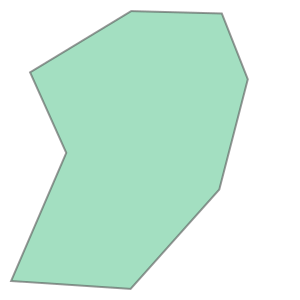

In [29]:
# WE are only going to grid lines that are within the Keep River plain area
# Open a polyon to use as a spatial mask

# Open geometry for a shapefile. This will be used to filter the bores extracted from the database
c = fiona.open(r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\Neil\Keep_spatial\Keep_River_polygons.shp")
collection = [ shape(item['geometry']) for item in c ]
names = [item['properties']['Name'] for item in c]
polygons = [Polygon(pol.exterior.coords) for pol in collection] 

# Buffer by 5000 metres
OrdKeep = polygons[names.index('DENR_model_outline')]

# Now keep only bores that are within 
OrdKeep

In [31]:
OrdKeep.bounds

(448510.40903862286, 8237140.634983661, 557496.2158347503, 8365049.777662147)

In [32]:
grids, grid_wkt, geotransoform = cond_point_utils.grid_points(grid_resolution = 100.,
                                                             variables = 'conductivity',
                                                             reprojected_grid_bounds = OrdKeep.bounds,
                                                             grid_wkt = wkt)

In [24]:
OrdKeep.wkt

'POLYGON ((503725.1616292503 8365005.710026997, 503797.9112354947 8365049.777662147, 545533.9824877982 8363955.027693332, 557487.5911249644 8333684.793186628, 557496.2158347503 8333662.952753694, 544392.6445761472 8283029.217971241, 544357.8626615324 8282894.816577523, 503524.2702587695 8237140.634983661, 448598.5557859408 8240759.81529371, 448510.4090386229 8240765.623483469, 473911.8997739411 8299766.09539283, 473902.8962494675 8299786.129389727, 457250.0834351546 8336857.594840728, 503725.1616292503 8365005.710026997))'

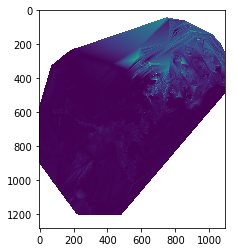

In [38]:
import matplotlib.pyplot as plt

plt.imshow(grids[:,:,0])

plt.show()

In [37]:
grids.shape

(1280, 1090, 30)

In [40]:
def grid_points_gdal(cond_point_utils_inst, grid_resolution, 
                variables=None, 
                native_grid_bounds=None, 
                reprojected_grid_bounds=None, 
                resampling_method='linear', 
                grid_wkt=None, 
                point_step=1):
    '''
    Function that grids points in a specified bounding rectangle to a 
    regular grid of the specified resolution and crs using gdal gridding functions
    @parameter grid_resolution: cell size of regular grid in grid CRS units
    @parameter variables: Single variable name string or list of multiple variable name strings. Defaults to all point variables
    @parameter native_grid_bounds: Spatial bounding box of area to grid in native coordinates 
    @parameter reprojected_grid_bounds: Spatial bounding box of area to grid in grid coordinates
    @parameter resampling_method: Resampling method for gridding. 'linear' (default), 'nearest' or 'cubic'. 
    See https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html 
    @parameter grid_wkt: WKT for grid coordinate reference system. Defaults to native CRS
    @parameter point_step: Sampling spacing for points. 1 (default) means every point, 2 means every second point, etc.

    @return grids: dict of grid arrays keyed by variable name if parameter 'variables' value was a list, or
    a single grid array if 'variable' parameter value was a string
    @return wkt: WKT for grid coordinate reference system.
    @return geotransform: GDAL GeoTransform for grid
    '''
    assert not (native_grid_bounds and reprojected_grid_bounds), 'Either native_grid_bounds or reprojected_grid_bounds can be provided, but not both'
    # Grid all data variables if not specified
    variables = variables or cond_point_utils_inst.point_variables

    # Allow single variable to be given as a string
    single_var = (type(variables) == str)
    if single_var:
        variables = [variables]

    if native_grid_bounds:
        reprojected_grid_bounds = self.get_reprojected_bounds(native_grid_bounds, self.wkt, grid_wkt)
    elif reprojected_grid_bounds:
        native_grid_bounds = self.get_reprojected_bounds(reprojected_grid_bounds, grid_wkt, self.wkt)
    else: # No reprojection required
        native_grid_bounds = self.bounds
        reprojected_grid_bounds = self.bounds

    # Determine spatial grid bounds rounded out to nearest GRID_RESOLUTION multiple
    pixel_centre_bounds = (round(math.floor(reprojected_grid_bounds[0] / grid_resolution) * grid_resolution, 6),
                   round(math.floor(reprojected_grid_bounds[1] / grid_resolution) * grid_resolution, 6),
                   round(math.floor(reprojected_grid_bounds[2] / grid_resolution - 1.0) * grid_resolution + grid_resolution, 6),
                   round(math.floor(reprojected_grid_bounds[3] / grid_resolution - 1.0) * grid_resolution + grid_resolution, 6)
                   )

    grid_size = [pixel_centre_bounds[dim_index+2] - pixel_centre_bounds[dim_index] for dim_index in range(2)]

    # Extend area for points an arbitrary 4% out beyond grid extents for nice interpolation at edges
    expanded_grid_bounds = [pixel_centre_bounds[0]-grid_size[0]/50.0,
                            pixel_centre_bounds[1]-grid_size[0]/50.0,
                            pixel_centre_bounds[2]+grid_size[1]/50.0,
                            pixel_centre_bounds[3]+grid_size[1]/50.0
                            ]

    spatial_subset_mask = cond_point_utils_inst.get_spatial_mask(cond_point_utils_inst.get_reprojected_bounds(expanded_grid_bounds, grid_wkt, self.wkt))

    # Create grids of Y and X values. Note YX ordering and inverted Y
    # Note GRID_RESOLUTION/2.0 fudge to avoid truncation due to rounding error
    grid_y, grid_x = np.mgrid[pixel_centre_bounds[3]:pixel_centre_bounds[1]-grid_resolution/2.0:-grid_resolution, 
                             pixel_centre_bounds[0]:pixel_centre_bounds[2]+grid_resolution/2.0:grid_resolution]

    # Skip points to reduce memory requirements
    #TODO: Implement function which grids spatial subsets.
    point_subset_mask = np.zeros(shape=(cond_point_utils_inst.netcdf_dataset.dimensions['point'].size,), dtype=bool)
    point_subset_mask[0:-1:point_step] = True
    point_subset_mask = np.logical_and(spatial_subset_mask, point_subset_mask)
    

    coordinates = self.xycoords[point_subset_mask]
    # Reproject coordinates if required
    if grid_wkt is not None:
        # N.B: Be careful about XY vs YX coordinate order         
        coordinates = np.array(transform_coords(coordinates[:], cond_point_utils_inst.wkt, grid_wkt))
    
    # Create a temporary shapefile with coords
    
    tempfile = os.path.join(tempfile.gettempdir(), 'AEM_pts_temp.csv')
    with open(tempfile, 'w') as f:
        f.write()
    
    # Interpolate required values to the grid - Note YX ordering for image
    grids = {}
    for variable in [cond_point_utils_inst.netcdf_dataset.variables[var_name] for var_name in variables]:
        
        
        
        grids[variable.name] = griddata(coordinates[:,::-1],
                              variable[:][point_subset_mask], #TODO: Check why this is faster than direct indexing
                              (grid_y, grid_x),
                              method=resampling_method)

    if single_var:
        grids = list(grids.values())[0]

    #  crs:GeoTransform = "109.1002342895272 0.00833333 0 -9.354948067227777 0 -0.00833333 "
    geotransform = [pixel_centre_bounds[0]-grid_resolution/2.0,
                    grid_resolution,
                    0,
                    pixel_centre_bounds[3]+grid_resolution/2.0,
                    0,
                    -grid_resolution
                    ] 

    return grids, (grid_wkt or cond_point_utils_inst.wkt), geotransform